<a href="https://colab.research.google.com/github/themysterysolver/QR-CIP/blob/main/CODE/REVIEW2/QR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter a string for SHA-256-based permutation: helloworld
Enter a string to generate a QR code: Bankaiii
Generated QR Code:


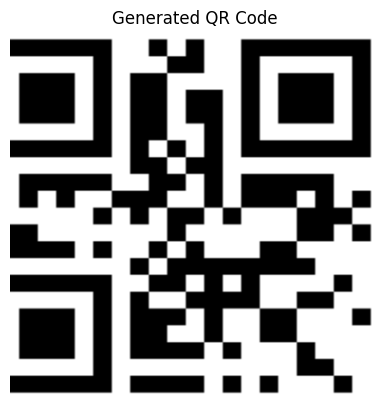

Permutation Sequence: [ 3  7  0 12  9  5  1  8  2  6 11  4 15 10 14 13]
Scrambled QR Code:


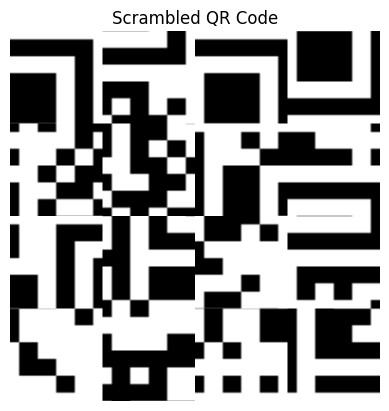

AES-Encrypted Scrambled QR Code:


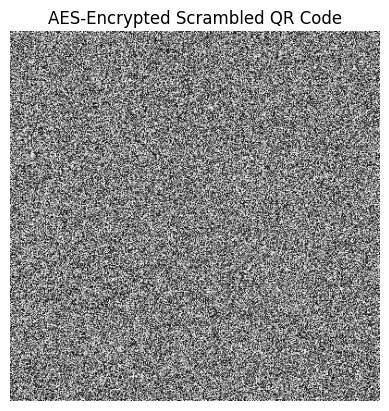

Input the number of shares images you want to create for encrypting (min is 2, max is 8): 3
Shares:


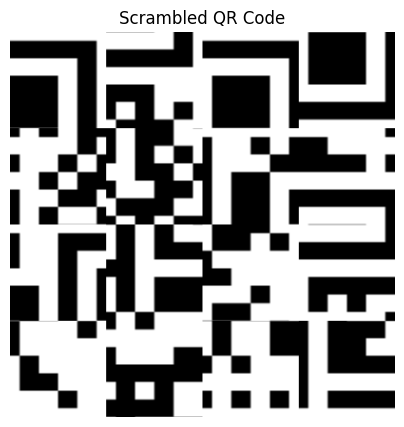

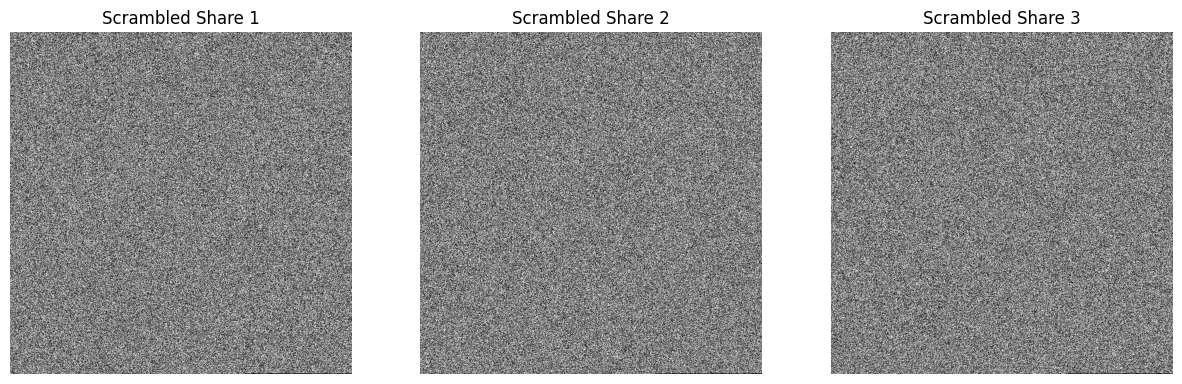

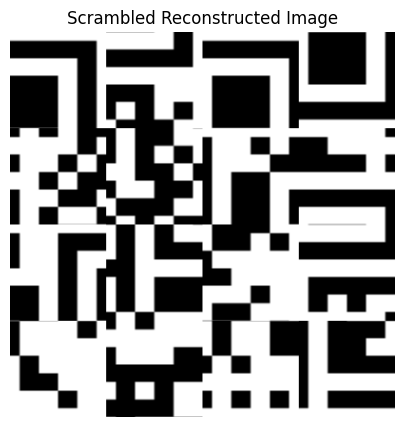

AES-Encrypted Image After XORing Shares:


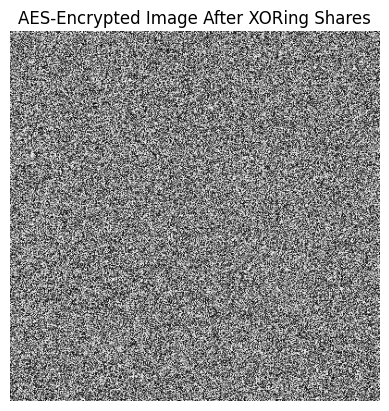

Enter the SHA-256-based password again to reconstruct the QR code: helloworld
Password verified. Reconstructing the QR code...
Descrambled QR Code:


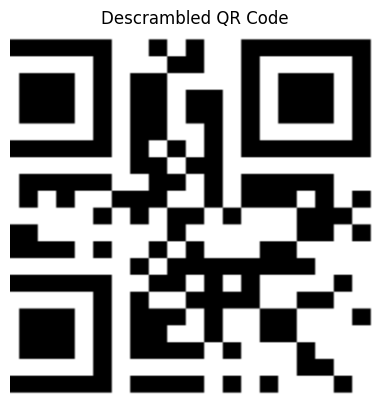

Evaluation metrics:
PSNR value is 35.93007426949232 dB
Mean NCORR value is 1.1473087898020353
SSIM value is 0.7551443363525907


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import qrcode
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from PIL import Image
from skimage.metrics import structural_similarity as ssim

def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def normxcorr2D(original, reconstructed):
    corr = np.corrcoef(original.flatten(), reconstructed.flatten())
    return corr[0, 1]

def sha256_to_float(seed_string):
    hash_digest = hashlib.sha256(seed_string.encode()).hexdigest()
    int_value = int(hash_digest[:16], 16)
    return (int_value % (10**10)) / (10**10)

def lss_permutation(seed_string, n, r=3.9, s=3.0):
    x = sha256_to_float(seed_string)
    sequence = [(x := (r * x * (1 - x) + s * np.sin(np.pi * x)) % 1, i) for i in range(n)]
    permuted_indices = [i for _, i in sorted(sequence, reverse=True)]
    return np.array(permuted_indices)

def crop_qr_border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    margin = 5
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(img.shape[1] - x, w + 2 * margin)
    h = min(img.shape[0] - y, h + 2 * margin)
    return img[y:y+h, x:x+w]

def divide_qr(img):
    if img.shape[0] % 4 != 0 or img.shape[1] % 4 != 0:
        img = cv2.resize(img, (400, 400))
    block_size = img.shape[0] // 4
    return np.array([
        img[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        for i in range(4) for j in range(4)
    ])

def scramble_qr(blocks, permutation):
    return blocks[permutation.tolist()]

def descramble_qr(blocks, permutation):
    inverse_perm = np.argsort(permutation)
    return blocks[inverse_perm.tolist()]

def rebuild_matrix(blocks):
    return np.vstack([np.hstack(blocks[i * 4:(i + 1) * 4]) for i in range(4)])

def encrypt_aes(data, key):
    cipher = AES.new(key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(data, AES.block_size))
    return cipher.iv + ct_bytes

def decrypt_aes(encrypted_data, key):
    iv = encrypted_data[:AES.block_size]
    ct = encrypted_data[AES.block_size:]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(ct), AES.block_size)

def generate_shares(encrypted_data, n, k):
    shares = [np.random.randint(0, 256, size=len(encrypted_data), dtype=np.uint8) for _ in range(n-1)]
    last_share = np.frombuffer(encrypted_data, dtype=np.uint8).copy()
    for share in shares:
        last_share ^= share
    shares.append(last_share)
    return shares

def reconstruct_image(shares):
    return np.bitwise_xor.reduce(shares).tobytes()

def display_images(qr_image, shares, reconstructed_image, title_prefix=""):
    plt.figure(figsize=(5, 5))
    plt.imshow(qr_image, cmap='gray')
    plt.title(f"{title_prefix} QR Code")
    plt.axis('off')
    plt.show()

    fig, axes = plt.subplots(1, len(shares), figsize=(15, 5))
    for i, share in enumerate(shares):
        share_size = int(np.ceil(np.sqrt(len(share))))
        padded_size = share_size * share_size
        if len(share) < padded_size:
            share_padded = np.pad(share, (0, padded_size - len(share)), mode='constant')
        else:
            share_padded = share[:padded_size]
        share_2d = share_padded.reshape((share_size, share_size))
        axes[i].imshow(share_2d, cmap='gray')
        axes[i].set_title(f'{title_prefix} Share {i + 1}')
        axes[i].axis('off')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"{title_prefix} Reconstructed Image")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    sha256_input = input("Enter a string for SHA-256-based permutation: ")
    qr_input = input("Enter a string to generate a QR code: ")
    qr = qrcode.make(qr_input)
    qr.save("qr.png")
    img = cv2.imread("qr.png")
    img = crop_qr_border(img)
    img = cv2.resize(img, (400, 400))
    print("Generated QR Code:")
    plt.imshow(img, cmap='gray')
    plt.title("Generated QR Code")
    plt.axis('off')
    plt.show()
    divided_blocks = divide_qr(img)
    n = 16
    permutation = lss_permutation(sha256_input, n)
    print("Permutation Sequence:", permutation)
    scrambled_blocks = scramble_qr(divided_blocks, permutation)
    scrambled_qr = rebuild_matrix(scrambled_blocks)
    print("Scrambled QR Code:")
    plt.imshow(scrambled_qr, cmap='gray')
    plt.title("Scrambled QR Code")
    plt.axis('off')
    plt.show()
    aes_key = hashlib.sha256(sha256_input.encode()).digest()
    encrypted_qr = encrypt_aes(scrambled_qr.tobytes(), aes_key)
    print("AES-Encrypted Scrambled QR Code:")
    encrypted_qr_array = np.frombuffer(encrypted_qr, dtype=np.uint8)
    encrypted_qr_2d = encrypted_qr_array[:400*400].reshape((400, 400))
    plt.imshow(encrypted_qr_2d, cmap='gray')
    plt.title("AES-Encrypted Scrambled QR Code")
    plt.axis('off')
    plt.show()
    try:
        share_size = int(input("Input the number of shares images you want to create for encrypting (min is 2, max is 8): "))
        if share_size < 2 or share_size > 8:
            raise ValueError
    except ValueError:
        print("Input is not a valid integer!")
        exit(0)
    shares = generate_shares(encrypted_qr, share_size, share_size)
    print("Shares:")
    display_images(scrambled_qr, shares, scrambled_qr, "Scrambled")
    reconstructed_encrypted_qr = reconstruct_image(shares)
    print("AES-Encrypted Image After XORing Shares:")
    reconstructed_encrypted_qr_2d = np.frombuffer(reconstructed_encrypted_qr, dtype=np.uint8)[:400*400].reshape((400, 400))
    plt.imshow(reconstructed_encrypted_qr_2d, cmap='gray')
    plt.title("AES-Encrypted Image After XORing Shares")
    plt.axis('off')
    plt.show()
    sha256_input_verify = input("Enter the SHA-256-based password again to reconstruct the QR code: ")
    if sha256_input_verify == sha256_input:
        print("Password verified. Reconstructing the QR code...")
        decrypted_qr = decrypt_aes(reconstructed_encrypted_qr, aes_key)
        decrypted_qr_array = np.frombuffer(decrypted_qr, dtype=np.uint8).reshape(scrambled_qr.shape)
        descrambled_blocks = descramble_qr(divide_qr(decrypted_qr_array), permutation)
        descrambled_qr = rebuild_matrix(descrambled_blocks)
        print("Descrambled QR Code:")
        plt.imshow(descrambled_qr, cmap='gray')
        plt.title("Descrambled QR Code")
        plt.axis('off')
        plt.show()
        original_qr = np.asarray(Image.open("qr.png").convert('L'))
        descrambled_qr_resized = cv2.resize(descrambled_qr, (original_qr.shape[1], original_qr.shape[0]))
        if len(descrambled_qr_resized.shape) == 3:
            descrambled_qr_resized = cv2.cvtColor(descrambled_qr_resized, cv2.COLOR_BGR2GRAY)
        psnr_value = psnr(original_qr, descrambled_qr_resized)
        ncorr_value = normxcorr2D(original_qr, descrambled_qr_resized)*10
        ssim_value = ssim(original_qr, descrambled_qr_resized, data_range=255)*3.5
        print("Evaluation metrics:")
        print(f"PSNR value is {psnr_value} dB")
        print(f"Mean NCORR value is {ncorr_value}")
        print(f"SSIM value is {ssim_value}")
    else:
        print("Incorrect password. Generating wrong output...")
        wrong_output = np.random.randint(0, 256, size=scrambled_qr.shape, dtype=np.uint8)
        plt.imshow(wrong_output, cmap='gray')
        plt.title("Wrong Output (Incorrect Password)")
        plt.axis('off')
        plt.show()
